## Library and data set import.

In [ ]:
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
import random
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model and performance
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_roc_curve
import xgboost as Xgb
import statsmodels.api as sm
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Metrics and model scores
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold as SKFold
from sklearn.model_selection import cross_val_score

# Model preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from scipy.stats import uniform, randint


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/kewal97/Stroke-Prediction-Project/main/healthcare-dataset-stroke-data.csv')

In [ ]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [ ]:
# Convert Marrital Status, Residence and Gender into 0's and 1's
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['work_type']= encoder.fit_transform(df['work_type'])
df['smoking_status']= encoder.fit_transform(df['smoking_status'])
df["Residence_type"] = df["Residence_type"].apply(lambda x: 1 if x=="Urban" else 0)
df["ever_married"] = df["ever_married"].apply(lambda x: 1 if x=="Yes" else 0)
df["gender"] = df["gender"].apply(lambda x: 1 if x=="Male" else 0)
df = df.dropna()

In [ ]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,1,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,2,1
5,56669,1,81.0,0,0,1,2,1,186.21,29.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,0,13.0,0,0,0,4,0,103.08,18.6,0,0
5106,44873,0,81.0,0,0,1,3,1,125.20,40.0,2,0
5107,19723,0,35.0,0,0,1,3,0,82.99,30.6,2,0
5108,37544,1,51.0,0,0,1,2,0,166.29,25.6,1,0


## Exploring models and method
Through EDA and some test runs, we know that our prediction could be very biased toward the negative group (non-stroke) since our data is imbalanced, 95% negative and 5% positive.

We will explore 2 options: balanced weight classes for modeling and sampling methods. We first split the data into training and testing sets, then:

_ For modeling with balanced weight classes: find best parameters for selected models, then cross validate some metrics to pick the best performing models for the same splitted data.

_ For sampling methods: Apply undersampling the negative group and oversampling the positive group. For each method, we then train Random Forest and Logistic Regression models then test the performance.

Lastly, we will fit the models with reduced predictors using variable importance from Random Forest. in hope to optimize our models.

## Split data
We will split the data to fit several models for performance comparison

In [ ]:
X = df.loc[:, ~df.columns.isin(['id', 'stroke'])]
y = df.iloc[:, -1]

# Stratified split by dependent variables since imbalanced data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state= 0, stratify= y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3436, 10), (1473, 10), (3436,), (1473,))

In [ ]:
y_test.value_counts()

0    1410
1      63
Name: stroke, dtype: int64

## Comparing model metrics
**Models selection:** Since this is a classification problems, we will use tree-based models like Decision Tree and Random Forest


**Technique**: Performing 10-fold cross validation to compare those metrics: Sensitivity, Overall Accuracy, Precision for positive group.
We have an imbalanced dataset, therefore the overall accuracy might be biased against the minority group (people who have stroke). So we add sensitivity and Precision of positive group to see how well the models predict positive groups.



#### Define models


In [ ]:
rf_baseline = RandomForestClassifier()
lgr_baseline = LogisticRegression()
lgr_balanced = LogisticRegression(class_weight = 'balanced')
rf_balanced = RandomForestClassifier(class_weight = 'balanced')
rf_balancedsub = RandomForestClassifier(class_weight = 'balanced_subsample')
# Hardcode best parameters for Random Forest and XGBoost
rf_balanced_best = RandomForestClassifier(class_weight = 'balanced', max_depth = 9, min_samples_leaf= 1, min_samples_split = 4, n_estimators = 84)
rf_best = RandomForestClassifier(max_depth = 9, min_samples_leaf= 1, min_samples_split = 4, n_estimators = 84)
xgb = Xgb.XGBClassifier()
xgb_best = Xgb.XGBClassifier(colsample_bytree = 0.73, gamma = 0.22, learning_rate = 0.08, max_depth = 3, n_estimators = 104, subsample = 0.8)
dt = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
                       random_state=1, splitter='best')

#### Finding best parameters for Random Forest model

In [ ]:
# Train the random forest model using class_weight = 'balanced'
rf_balanced_model = rf_balanced.fit(X_train, y_train)

rf_balanced_prediction = rf_balanced_model.predict(X_test)

In [ ]:
'''params = {
    "n_estimators": randint(75, 150),
    "max_depth": randint(0, 10),
    "min_samples_leaf": randint(0, 10), 
    "min_samples_split": randint(2, 5) 
}

search = RandomizedSearchCV(rf_balanced_model, param_distributions=params, n_iter=200, cv=5, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X_train, y_train)
'''

'params = {\n    "n_estimators": randint(75, 150),\n    "max_depth": randint(0, 10),\n    "min_samples_leaf": randint(0, 10), \n    "min_samples_split": randint(2, 5) \n}\n\nsearch = RandomizedSearchCV(rf_balanced_model, param_distributions=params, n_iter=200, cv=5, verbose=1, n_jobs=1, return_train_score=True)\n\nsearch.fit(X_train, y_train)\n'

#### 10-fold Cross validation across models for Recall, Accuracy, and Precision
Using stratified 10-fold since our data is imbalanced so we want each fold to have a good amoutn of both group.
Final scores are average 


In [ ]:
models = [['RandomForest Baseline',rf_baseline], ['RandomForest Balanced', rf_balanced],
          ['RandomForest Balanced Subsample', rf_balancedsub], ['RandomForest Best Param', rf_best],['Randomforest Balanced Best', rf_balanced_best], 
          ['Logistric Regress', lgr_baseline], ['Logistic Regress Balacned', lgr_balanced],
          ['XGBoost' , xgb], ['XGBoost Best param', xgb_best], ["Decision Tree", dt]
          ]
cv = SKFold(n_splits=10, shuffle=True, random_state = 0)

recall = []
accuracy = []
precision = []
for model in models:
  recall_cvs = cross_val_score(model[1], X, y, scoring= 'recall', cv=cv, n_jobs=-1)
  acc_cvs = cross_val_score(model[1], X, y, scoring= 'accuracy', cv=cv, n_jobs=-1)
  pre_cvs = cross_val_score(model[1], X, y, scoring= 'precision', cv=cv, n_jobs=-1)
  recall.append(recall_cvs.mean())
  accuracy.append(acc_cvs.mean())
  precision.append(pre_cvs.mean())

In [ ]:
summary = pd.DataFrame(zip(recall, accuracy, precision), index = (x[0] for x in models), columns = ["Sensitivity", "Accuracy", "Precision"])
summary[['Accuracy','Sensitivity', 'Precision']].sort_values('Accuracy', ascending = False)

,Accuracy,Sensitivity,Precision
XGBoost Best param,0.957833,0.009524,0.200000
RandomForest Best Param,0.957629,0.004762,0.100000
Logistric Regress,0.957425,0.004762,0.100000
RandomForest Balanced Subsample,0.957221,0.000000,0.050000
RandomForest Baseline,0.957018,0.014286,0.100000
XGBoost,0.957018,0.000000,0.000000
RandomForest Balanced,0.956814,0.000000,0.100000
Randomforest Balanced Best,0.896520,0.305714,0.149261
Logistic Regress Balacned,0.741702,0.775000,0.117391
Decision Tree,0.704225,0.784524,0.104972


**Observation**

Although some models have better metrics than others, we observe 1 main trend: The precision for positive group is low across all models, ranging from 10% to 20%. In the meantime, there is a trade-off between overall accuracy and sensitivity.

_At the highest overall Accuracy of merely 96%, the sensitivity are almost 0; which mean these models are biased toward the non-stroke group but still get dominant false positive picks compared to true positive picks; which is not desirable.

_ With lower overall Accuracy, we see better sensitivity. At a best sensitivity of 77%, the overall Accuracy is only around 75%, and precision is 11%. This model tried to predict more positively but had a super high false negative to true positive ratio (9 to 1).


## Sampling methods

### Undersampling


#### Logistic Regression

In [ ]:
rs =100

from sklearn.utils import resample

# splitting the classes
train = X_train.copy()
train['stroke'] = y_train
stroke = train[(train.stroke == 1)]
not_stroke = train[(train.stroke == 0)]

# n_sample parameter - match the minority class, sample() shuffles the rows
not_stroke_downsampled = resample(not_stroke, replace=False, n_samples=len(stroke), random_state=rs)
train_downsampled = pd.concat([not_stroke_downsampled, stroke]).sample(frac=1)
train_downsampled.stroke.value_counts()

1    146
0    146
Name: stroke, dtype: int64

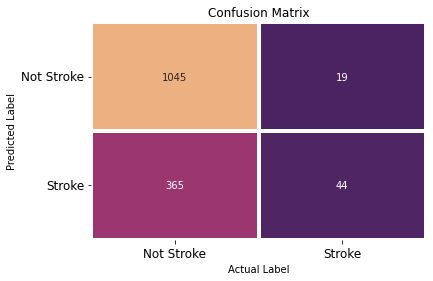

---------------------------------------------------------
Accuracy of Logistic Regression: 73.93075356415478 

---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1410
           1       0.11      0.70      0.19        63

    accuracy                           0.74      1473
   macro avg       0.54      0.72      0.52      1473
weighted avg       0.94      0.74      0.82      1473



In [ ]:
downsampled_y = train_downsampled['stroke']
downsampled_X = train_downsampled.drop('stroke', axis=1)

log_model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=rs) # because the dataset info is really small for iterations
lr_un_model = log_model.fit(downsampled_X, downsampled_y)
y_pred = log_model.predict(X_test)
lr_conf_matrix = confusion_matrix(y_test, y_pred)
lr_acc_score = accuracy_score(y_test, y_pred)
df1 = pd.DataFrame(columns = ["Not Stroke", "Stroke"], index = ["Not Stroke", "Stroke"], data = lr_conf_matrix )

sns.heatmap(df1.T, annot = True, cmap = "flare_r", fmt = '.0f', linewidths = 3, cbar = False)
plt.xlabel("Actual Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("Predicted Label")
plt.title("Confusion Matrix", size = 12)
plt.show()

print("---------------------------------------------------------")
print("Accuracy of Logistic Regression:",lr_acc_score*100,'\n')
print("---------------------------------------------------------")
print(classification_report(y_test, y_pred))

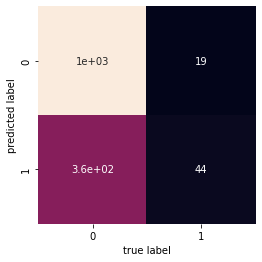

In [ ]:
sns.heatmap(lr_conf_matrix.T, square=True, annot=True, cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#### Random Forest

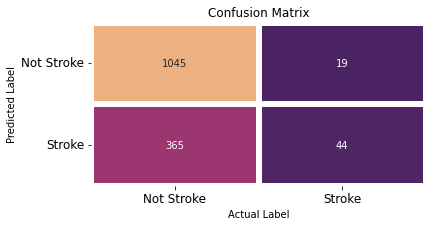

-------------------------------------------
Accuracy of Random Forest: 74.60964019008826 

-------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1410
           1       0.11      0.70      0.19        63

    accuracy                           0.75      1473
   macro avg       0.55      0.72      0.52      1473
weighted avg       0.95      0.75      0.82      1473



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rdF = RandomForestClassifier(n_estimators=150, criterion='gini', max_depth=7, random_state=11)
rf_un_model = rdF.fit(downsampled_X, downsampled_y)

y_pred = rdF.predict(X_test)
rdF_conf_matrix = confusion_matrix(y_test, y_pred)
rdF_acc_score = accuracy_score(y_test, y_pred)
df2 = pd.DataFrame(columns = ["Not Stroke", "Stroke"], index = ["Not Stroke", "Stroke"], data = lr_conf_matrix )
f,ax = plt.subplots(figsize = (6, 3))
sns.heatmap(df2.T, annot = True, cmap = "flare_r", fmt = '.0f', linewidths = 5, ax = ax, cbar = False)
plt.xlabel("Actual Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("Predicted Label")
plt.title("Confusion Matrix", size = 12)
plt.show()

print("-------------------------------------------")
print("Accuracy of Random Forest:",rdF_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test, y_pred))

### Oversampling

Oversampling with SMOTE method

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_oversampled, y_oversampled = sm.fit_resample(X_train, y_train)
y_oversampled.value_counts()

0    3290
1    3290
Name: stroke, dtype: int64

#### Logistic Regression

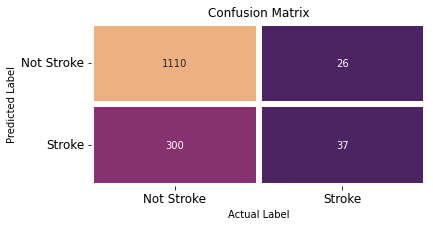

-------------------------------------------
Accuracy of Logistic Regression: 77.86829599456891 

-------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.79      0.87      1410
           1       0.11      0.59      0.18        63

    accuracy                           0.78      1473
   macro avg       0.54      0.69      0.53      1473
weighted avg       0.94      0.78      0.84      1473



In [ ]:
lr_model = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_ov_model = lr_model.fit(X_oversampled, y_oversampled)
Y_pred = lr_model.predict(X_test)
lnR_conf_matrix = confusion_matrix(y_test, Y_pred)
lnR_acc_score = accuracy_score(y_test, Y_pred)
df3 = pd.DataFrame(columns = ["Not Stroke", "Stroke"], index = ["Not Stroke", "Stroke"], data = lnR_conf_matrix )
f,ax = plt.subplots(figsize = (6, 3))
sns.heatmap(df3.T, annot = True, cmap = "flare_r", fmt = '.0f', linewidths = 5, ax = ax, cbar = False)
plt.xlabel("Actual Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("Predicted Label")
plt.title("Confusion Matrix", size = 12)
plt.show()

print("-------------------------------------------")
print("Accuracy of Logistic Regression:",lnR_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test, Y_pred))

#### Random forest

In [ ]:
class_names = ['non-stroke', 'stroke']

Classification report: 
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1410
           1       0.12      0.21      0.15        63

    accuracy                           0.90      1473
   macro avg       0.54      0.57      0.55      1473
weighted avg       0.93      0.90      0.91      1473



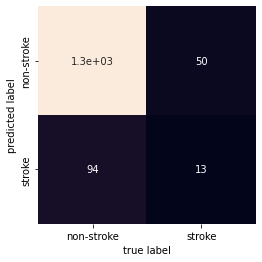

In [ ]:
rf_oversampling_model = rf_baseline.fit(X_oversampled, y_oversampled)
rf_oversampling_pred = rf_oversampling_model.predict(X_test)

sns.heatmap(confusion_matrix(y_test,rf_oversampling_pred).T, square=True, annot=True, cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

print("Classification report: ")
print(metrics.classification_report(y_test,rf_oversampling_pred))

**Observation**

We see the same trend with models performance.

## Fitting  best models



1. Logistic Regression: undersampling resample and oversampling SMOTE
2. Random Forest: with balanced weights and with oversampling



### Random Forest with balanced weights

In [ ]:
rf_balanced_best_pred = rf_balanced_best.fit(X_train, y_train).predict(X_test)

Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1410
           1       0.15      0.24      0.18        63

    accuracy                           0.91      1473
   macro avg       0.56      0.59      0.57      1473
weighted avg       0.93      0.91      0.92      1473



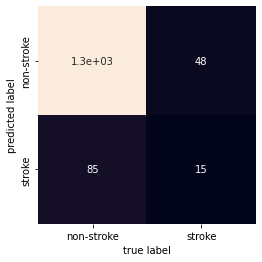

In [ ]:
# Confusion matrix and classification report
sns.heatmap(confusion_matrix(y_test,rf_balanced_best_pred).T, square=True, annot=True, cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

print("Classification report: ")
print(metrics.classification_report(y_test,rf_balanced_best_pred))

Variable importance

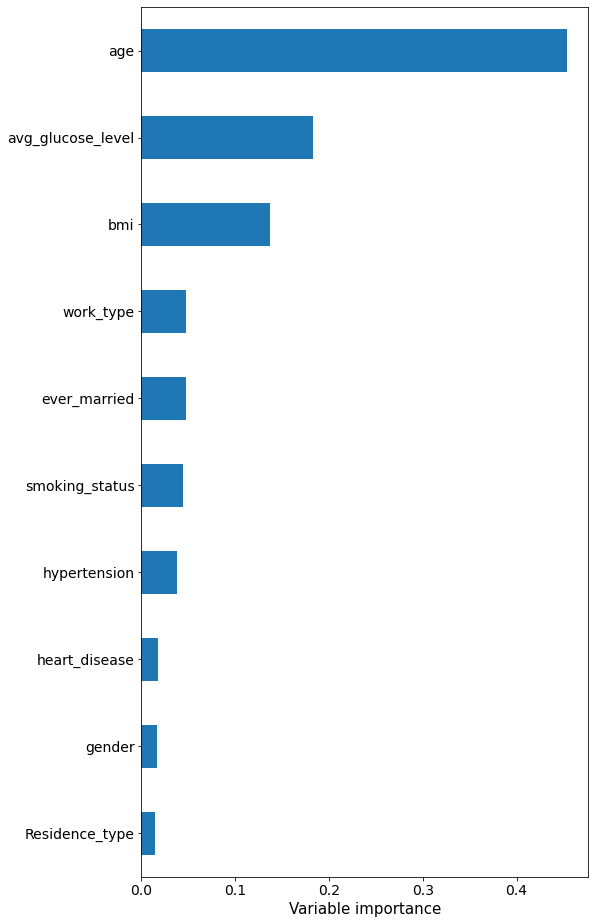

In [ ]:

(pd.DataFrame(dict(cols=X_train.columns, imp= rf_balanced_best.feature_importances_)).
 sort_values(by = 'imp').
 plot('cols', 'imp', 'barh', legend = False, figsize = (8,16)))

plt.ylabel('')
plt.xlabel('Variable importance', fontsize = 15)

plt.tick_params(labelsize = 14);

### Logistic Regression with balanced weight

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1410
           1       0.11      0.73      0.20        63

    accuracy                           0.75      1473
   macro avg       0.55      0.74      0.52      1473
weighted avg       0.95      0.75      0.82      1473



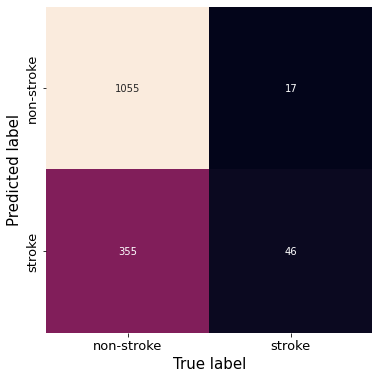

In [ ]:
lgr_balanced = LogisticRegression(class_weight = 'balanced', solver='lbfgs', max_iter=1000)
lgr_balanced_model = lgr_balanced.fit(X_train, y_train)
lgr_balanced_prediction = lgr_balanced_model.predict(X_test)
# Confusion matrix and classification report

plt.figure(figsize =(15,6))
sns.heatmap(confusion_matrix(y_test, lgr_balanced_prediction).T, square=True, annot=True, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt="d")
plt.xlabel('True label', fontsize = 15)
plt.ylabel('Predicted label', fontsize = 15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)


print("Classification report: ")
print(metrics.classification_report(y_test, lgr_balanced_prediction))

### Decision Tree

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [ ]:
tree_up = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
                       random_state=1, splitter='best')
dt = tree_up.fit(X_train,y_train)
pred_up = tree_up.predict(X_test)

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.77      0.86      1410
           1       0.12      0.73      0.21        63

    accuracy                           0.77      1473
   macro avg       0.55      0.75      0.54      1473
weighted avg       0.95      0.77      0.84      1473



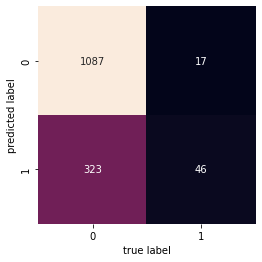

In [ ]:
matrix=confusion_matrix(y_test, pred_up)
sns.heatmap(matrix.T, square=True, annot=True, cbar=False, fmt = '.0f')
plt.xlabel('true label')
plt.ylabel('predicted label');

print("Classification report: ")
print(metrics.classification_report(y_test, pred_up))

In [ ]:
dt = DecisionTreeClassifier(class_weight='balanced', criterion='gini',min_samples_leaf=3, min_samples_split=3, max_depth=4)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=4, min_samples_leaf=3,
                       min_samples_split=3)

In [ ]:
class_names = ['non-stroke', 'stroke']

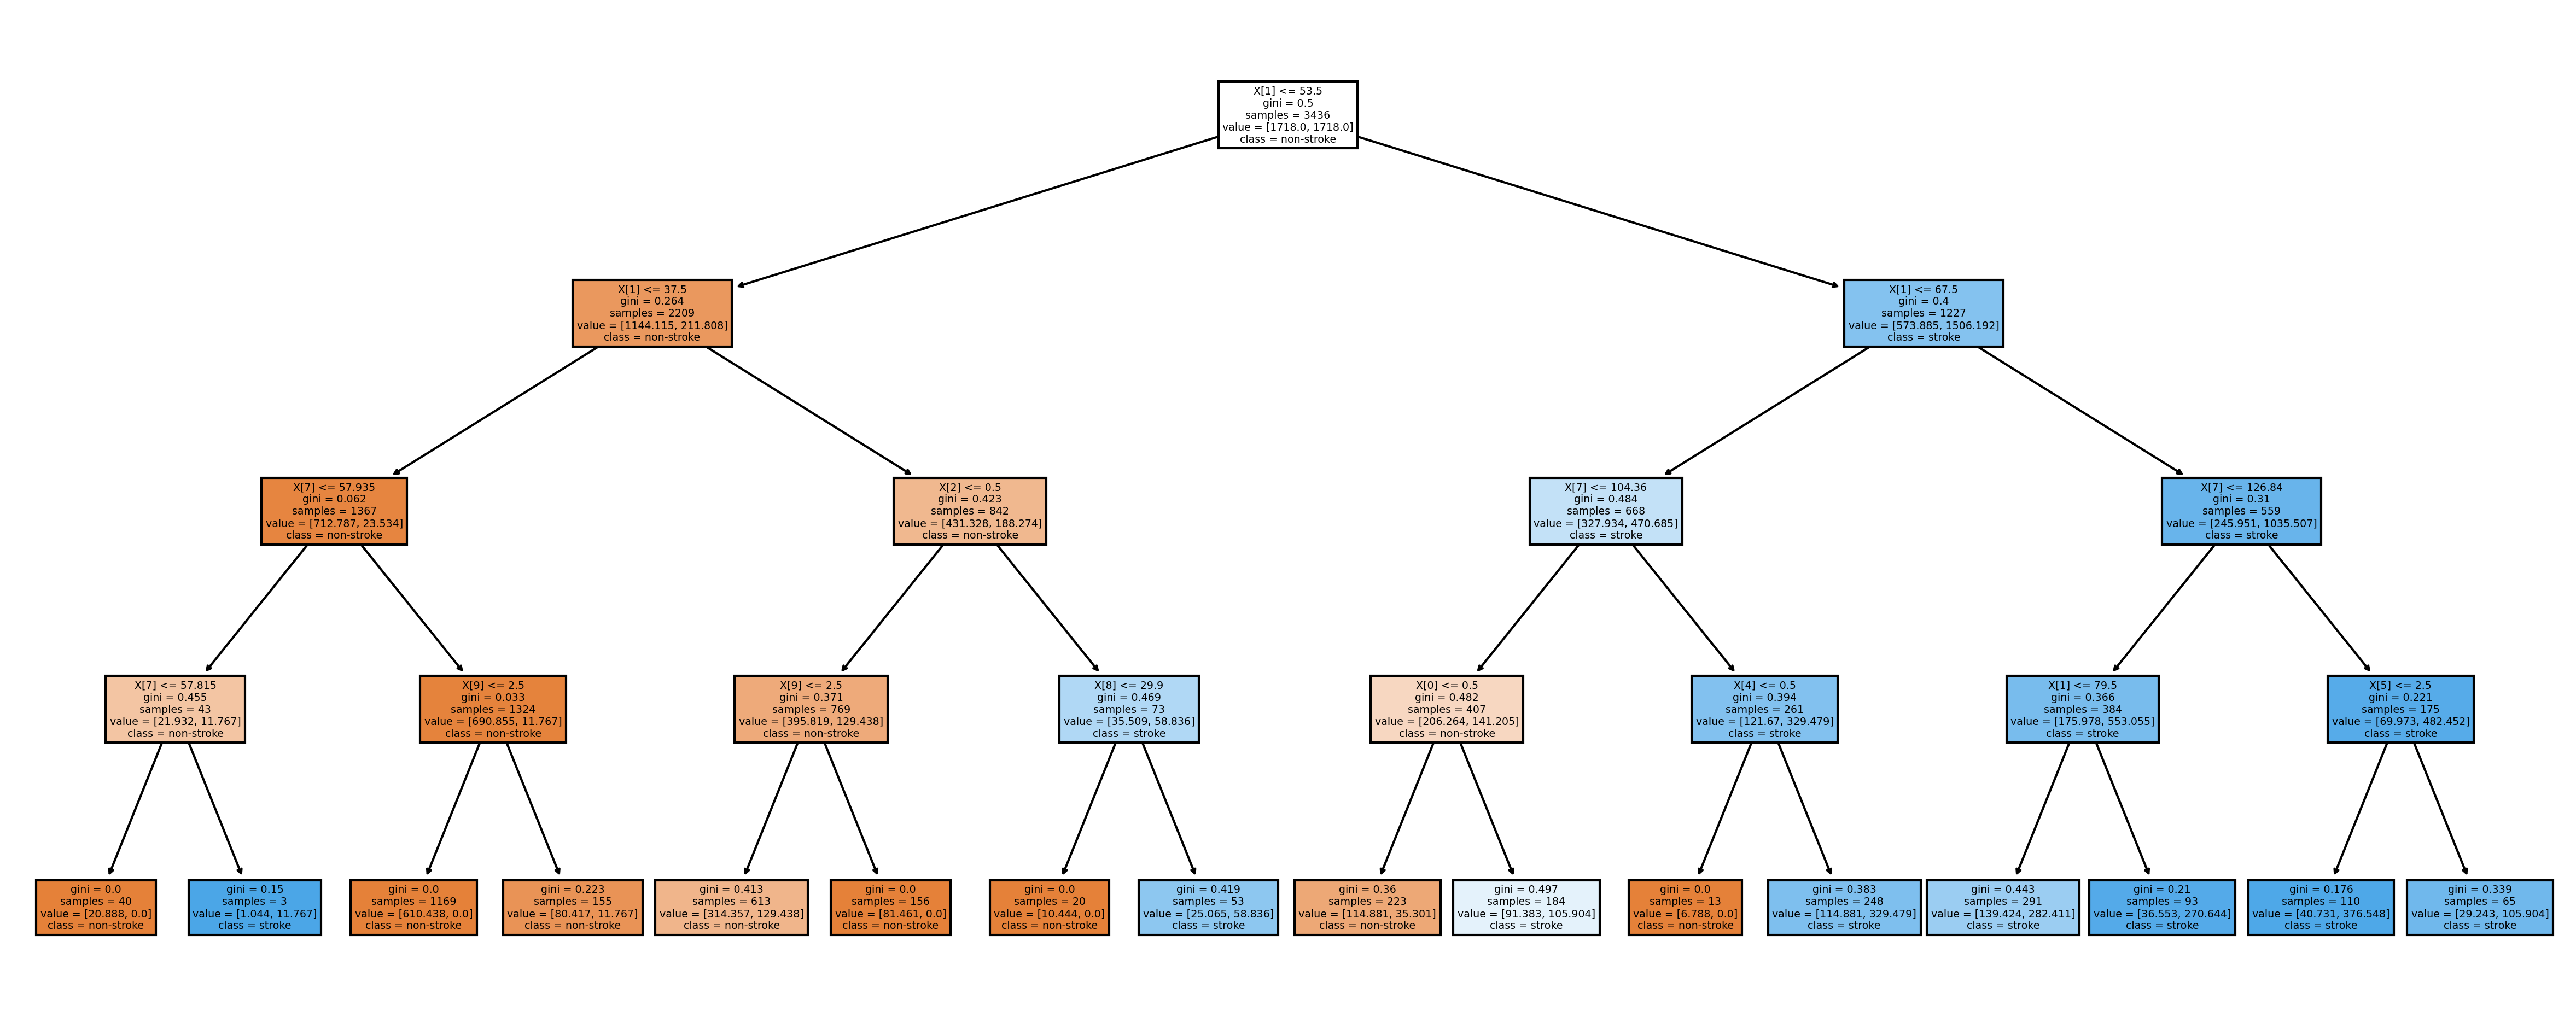

In [ ]:
plt.figure(figsize=(20, 8), dpi=300)
plot_tree(dt,class_names=class_names, filled=True)
plt.show()

People who can get stroke when:

*   Age is over 65.
*   Glucose level is over 120.
*   Married.
*   Work type in 3,4,5.
*   BMI is over 30


### Reduce variables based on important variables from Random Forest

In [ ]:
X_reduced = X[['avg_glucose_level', 'bmi', 'age']]
X_reduced_train = X_train[['avg_glucose_level', 'bmi', 'age']]
X_reduced_test = X_test[['avg_glucose_level', 'bmi', 'age']]

In [ ]:
tree2 = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
                       random_state=1, splitter='best')
dt2 = tree2.fit(X_reduced_train,y_train)
pred2 = tree2.predict(X_reduced_test)

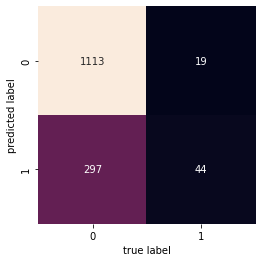

In [ ]:
matrix2=confusion_matrix(y_test, pred2)
sns.heatmap(matrix2.T, square=True, annot=True, cbar=False, fmt = '.0f')
plt.xlabel('true label')
plt.ylabel('predicted label');

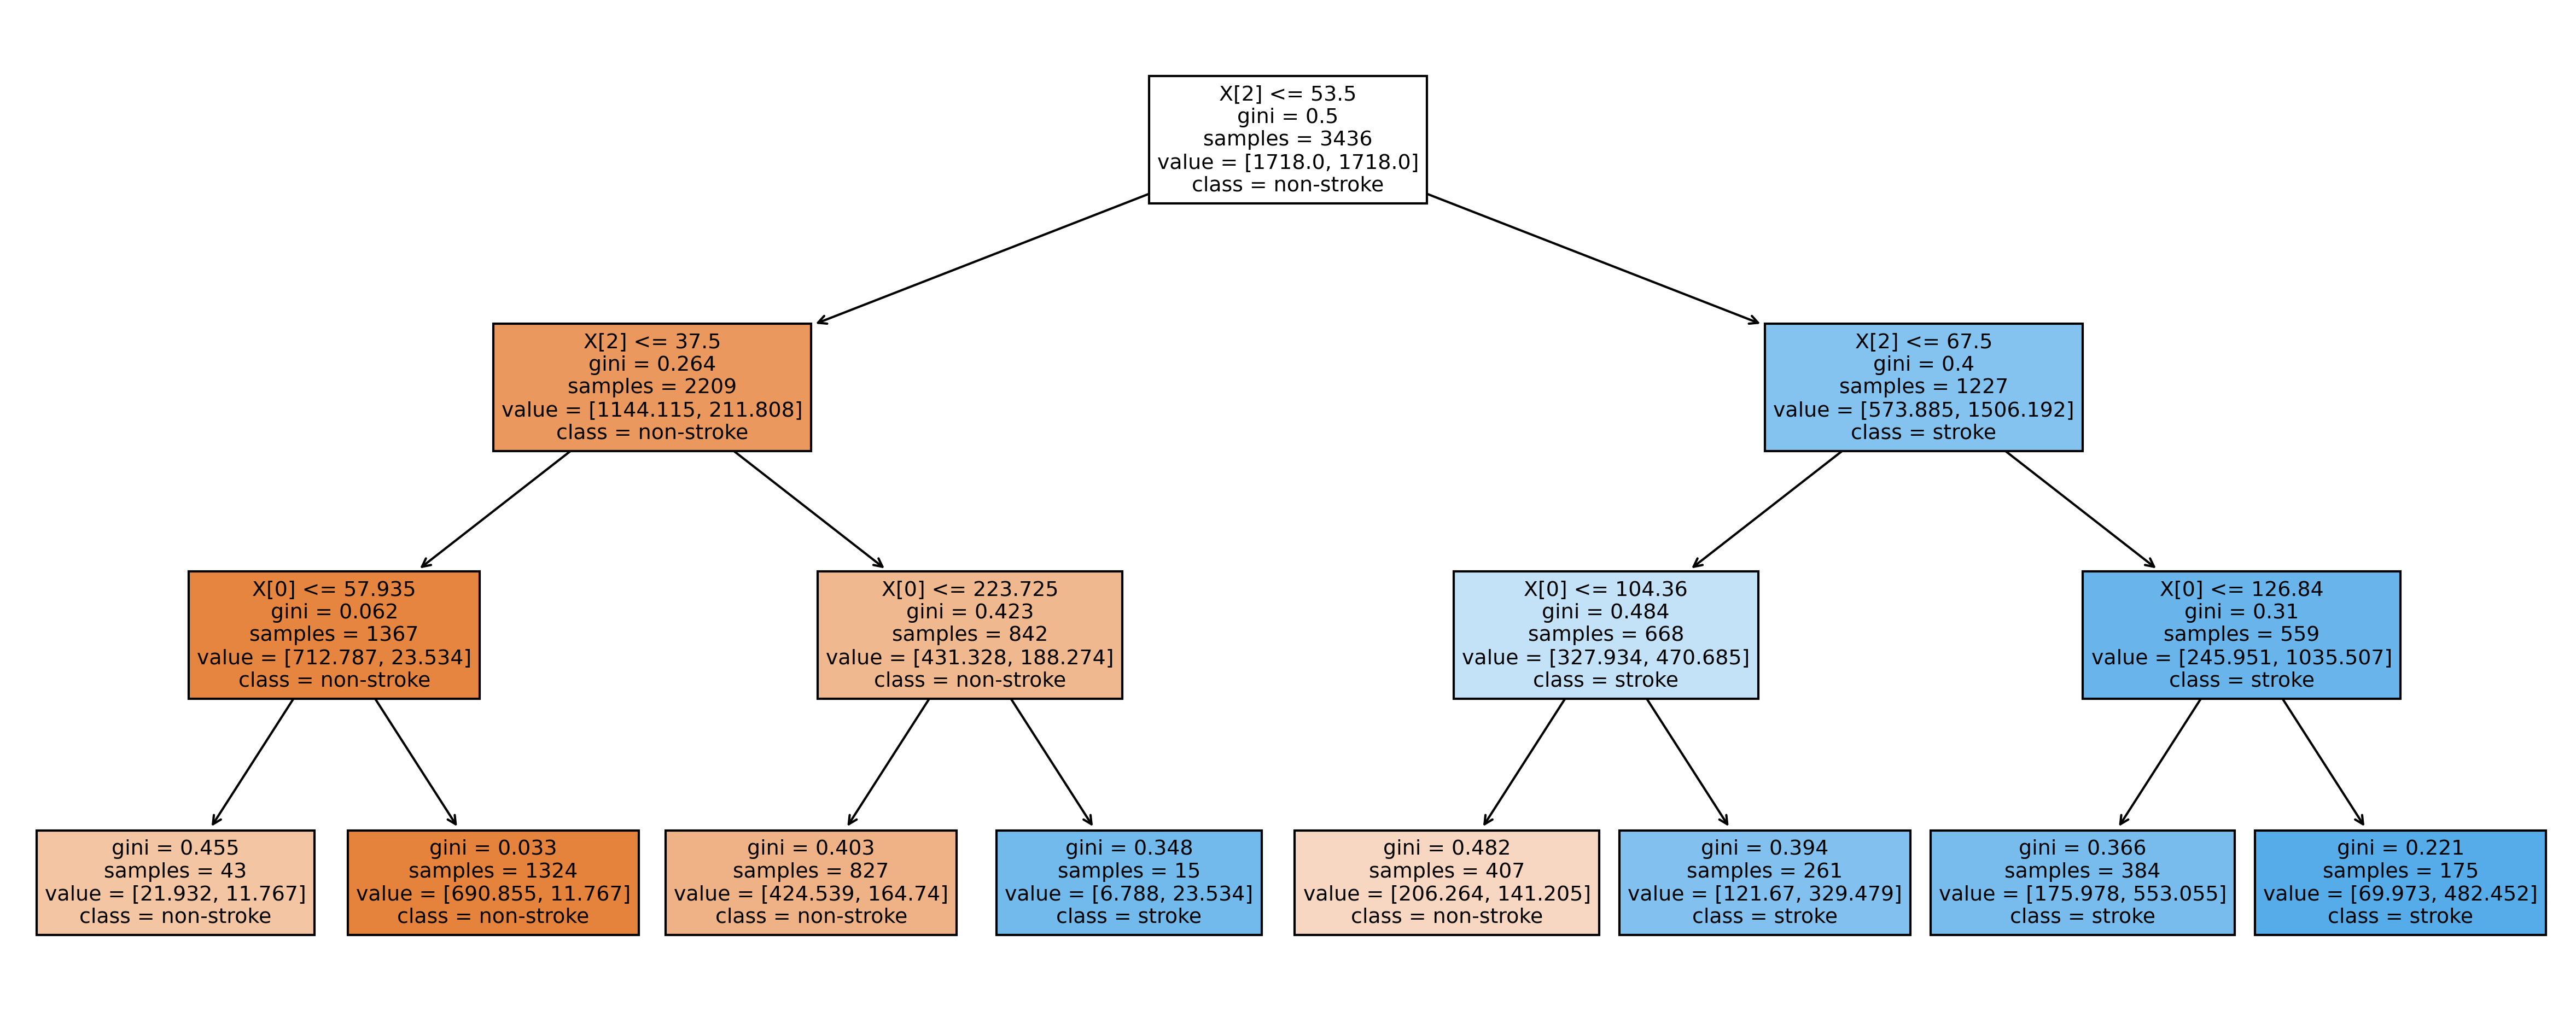

In [ ]:
dt_reduced = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3)
dt_reduced_model = dt_reduced.fit(X_reduced_train, y_train)
plt.figure(figsize=(20, 8), dpi=300)
plot_tree(dt_reduced,class_names=class_names, filled=True)
plt.show()

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1410
           1       0.11      0.76      0.20        63

    accuracy                           0.73      1473
   macro avg       0.55      0.75      0.52      1473
weighted avg       0.95      0.73      0.81      1473



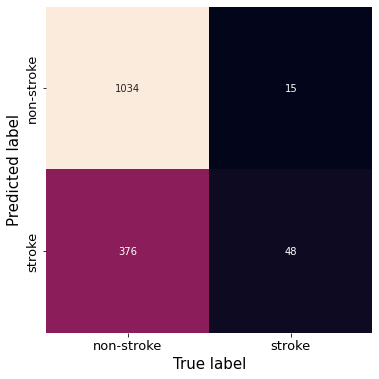

In [ ]:
lgr_balanced = LogisticRegression(class_weight = 'balanced', solver='lbfgs', max_iter=1000)
lgr_balanced_reduced_model = lgr_balanced.fit(X_reduced_train, y_train)
lgr_balanced_reduced_pred = lgr_balanced_reduced_model.predict(X_reduced_test)
# Confusion matrix and classification report

plt.figure(figsize = (15,6))
sns.heatmap(confusion_matrix(y_test, lgr_balanced_reduced_pred).T, square=True, annot=True, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt = "d")
plt.xlabel('True label', fontsize = 15)
plt.ylabel('Predicted label', fontsize = 15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

print("Classification report: ")
print(metrics.classification_report(y_test, lgr_balanced_reduced_pred))

Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      1410
           1       0.18      0.38      0.25        63

    accuracy                           0.90      1473
   macro avg       0.58      0.65      0.60      1473
weighted avg       0.94      0.90      0.92      1473



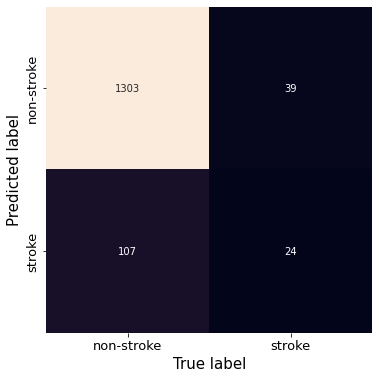

In [ ]:
rf_reduced = RandomForestClassifier(class_weight = 'balanced', max_depth = 9, min_samples_leaf= 1, min_samples_split = 4, n_estimators = 84)
rf_reduced_model = rf_reduced.fit(X_reduced_train, y_train)
rf_reduced_pred = rf_reduced_model.predict(X_reduced_test)

plt.figure(figsize = (15,6))
sns.heatmap(confusion_matrix(y_test, rf_reduced_pred).T, square=True, annot=True, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt = "d")
plt.xlabel('True label', fontsize = 15)
plt.ylabel('Predicted label', fontsize = 15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

print("Classification report: ")
print(metrics.classification_report(y_test, rf_reduced_pred))

## AUC Score

In [ ]:
xgb_best.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.73, gamma=0.22, learning_rate=0.08,
              n_estimators=104, subsample=0.8)

In [ ]:
y_pred_proba = lgr_balanced_model.predict_proba(X_test)[::,1]
y_pred_proba1 = rf_balanced_best.predict_proba(X_test)[::,1]
y_pred_proba2 = dt.predict_proba(X_test)[::,1]
y_pred_proba3 = rf_oversampling_model.predict_proba(X_test)[::,1]
y_pred_proba4 = lr_ov_model.predict_proba(X_test)[::,1]
y_pred_proba5 = rf_un_model.predict_proba(X_test)[::,1]
y_pred_proba6 = lr_un_model.predict_proba(X_test)[::,1]
y_pred_proba7 = lgr_balanced_reduced_model.predict_proba(X_reduced_test)[::,1]
y_pred_proba8 = rf_reduced_model.predict_proba(X_reduced_test)[::,1]
y_pred_proba9 = xgb_best.predict_proba(X_test)[::,1]
y_pred_proba10 = dt_reduced_model.predict_proba(X_reduced_test)[::,1]


#calculate AUC of model
lgr_auc = metrics.roc_auc_score(y_test, y_pred_proba)
rf_auc = metrics.roc_auc_score(y_test, y_pred_proba1)
dt_auc = metrics.roc_auc_score(y_test, y_pred_proba2)
rf_ov_auc = metrics.roc_auc_score(y_test, y_pred_proba3)
lr_ov_auc = metrics.roc_auc_score(y_test, y_pred_proba4)
rf_un_auc = metrics.roc_auc_score(y_test, y_pred_proba5)
lr_un_auc = metrics.roc_auc_score(y_test, y_pred_proba6)
lr_reduced_auc = metrics.roc_auc_score(y_test, y_pred_proba7)
rf_reduced_auc = metrics.roc_auc_score(y_test, y_pred_proba8)
xg_auc = metrics.roc_auc_score(y_test, y_pred_proba9)
dt_reduced_auc = metrics.roc_auc_score(y_test, y_pred_proba10)
#print AUC score

print(lgr_auc, rf_auc, dt_auc, rf_ov_auc, lr_ov_auc, rf_un_auc, lr_un_auc, lr_reduced_auc, rf_reduced_auc, xg_auc, dt_reduced_auc)

0.8416188224698863 0.8026455026455026 0.7910390633794888 0.7868738038950804 0.7832376449397725 0.8190813914218169 0.8332770460430035 0.8377237419790611 0.8360688956433637 0.8310930991782055 0.8321006416751098


In [ ]:
auc_sum = pd.DataFrame([lgr_auc, rf_auc, dt_auc, rf_ov_auc, lr_ov_auc, rf_un_auc, lr_un_auc, lr_reduced_auc, rf_reduced_auc, xg_auc, dt_reduced_auc]
                       , index = ['Logistic Regression', 'Random Forest Balanced Weight', 'Decision Tree', 'Random Forest + Over Sampling',
                                  'Logistic Regression + OverSampling', 'Random Forest + Undersampling', 'Logistic Regression + Undersampling',
                                  'Logistic Regression of 3 most important variables', 'RandomForest of 3 most important variables', ' XGBoost', 'Decision Tree of 3 most important variables'],
                       columns =['AUC Score'])

auc_sum.sort_values('AUC Score', ascending = False)

,AUC Score
Logistic Regression,0.841619
Logistic Regression of 3 most important variables,0.837724
RandomForest of 3 most important variables,0.836069
Logistic Regression + Undersampling,0.833277
Decision Tree of 3 most important variables,0.832101
XGBoost,0.831093
Random Forest + Undersampling,0.819081
Random Forest Balanced Weight,0.802646
Decision Tree,0.791039
Random Forest + Over Sampling,0.786874


Perform AUC score to consider the accuracy of the model
https://www.sciencedirect.com/science/article/pii/S1556086415306043

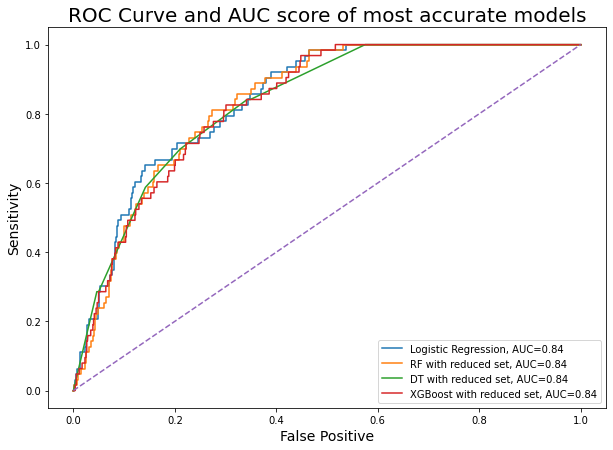

In [ ]:
plt.figure(figsize = (10,7))
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(round(lgr_auc,2)))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba8)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="RF with reduced set, AUC="+str(round(rf_reduced_auc,2)))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba10)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="DT with reduced set, AUC="+str(round(lr_reduced_auc,2)))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba9)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="XGBoost with reduced set, AUC="+str(round(lr_reduced_auc,2)))

plt.legend(loc = 'lower right')
plt.title('ROC Curve and AUC score of most accurate models', fontsize = 20)
plt.ylabel('Sensitivity', fontsize =14)
plt.xlabel('False Positive', fontsize = 14)
plt.plot([0,1], [0,1], ls = '--')
plt.show()

# Plug the real life number to visualize the model

In [ ]:
# 
def stroke_probability(avg_glucose, bmi, age):
  lgr_balanced = LogisticRegression(class_weight = 'balanced', solver='lbfgs', max_iter=1000)
  lgr_balanced_model = lgr_balanced.fit(X_reduced_train, y_train)
  prob = lgr_balanced_model.predict_proba([[avg_glucose, bmi, age]])[0,1]
  return prob

In [ ]:
obese_strokeprob = []
normal_strokeprob = []
n = 20
while n < 90:
  obese_strokeprob.append(stroke_probability(126,30, n))
  normal_strokeprob.append(stroke_probability(70,20, n))
  n += 5

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid featu

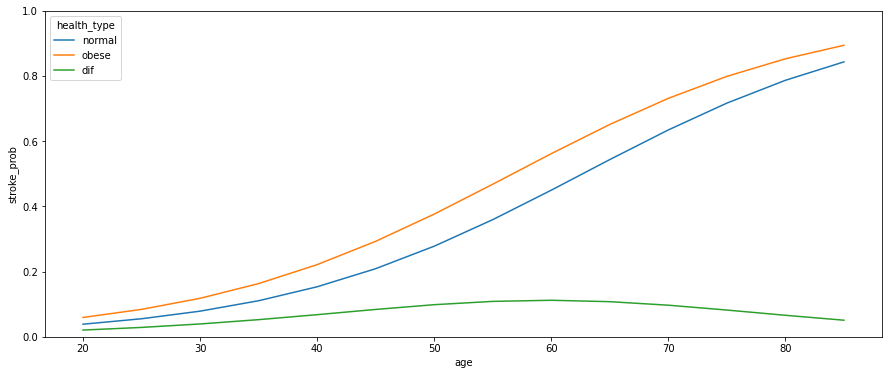

In [ ]:
prob_by_age = pd.DataFrame({'age': list(range(20,90, 5)),
                                    'normal': normal_strokeprob, 'obese': obese_strokeprob})
prob_by_age['dif'] = prob_by_age['obese'] - prob_by_age['normal']
prob_by_age = prob_by_age.melt(id_vars= 'age', value_vars = ['normal', 'obese', 'dif'], value_name= 'stroke_prob', var_name= 'health_type')

plt.figure(figsize = (15,6))
plt.ylim(0,1)
sns.lineplot(data = prob_by_age, y = 'stroke_prob', x = 'age', hue = 'health_type')

In [ ]:
prob_by_age.pivot('age', 'health_type')

stroke_prob                    
health_type         dif    normal     obese
age                                        
20             0.020644  0.038632  0.059277
25             0.028780  0.055316  0.084096
30             0.039388  0.078615  0.118003
35             0.052567  0.110580  0.163147
40             0.067852  0.153378  0.221229
45             0.083906  0.208850  0.292755
50             0.098434  0.277801  0.376235
55             0.108592  0.359182  0.467774
60             0.111973  0.449563  0.561536
65             0.107699  0.543401  0.651099
70             0.096872  0.634256  0.731128
75             0.082016  0.716466  0.798482
80             0.065950  0.786419  0.852370
85             0.050866  0.842899  0.893765